In [259]:
!pip install meteostat

from traceback import format_exc
from time import time
from meteostat import Point, Daily, Stations
import matplotlib.pyplot as plt
from sklearn import preprocessing
from datetime import datetime as dt
import seaborn
import calendar
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, StandardScaler
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [260]:
df_stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
df_train_partial = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
df_test_partial = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
df_transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

**Get Weather Data**
* We load min/max/avg temperature and precipitation from closest city weather station
* We clean the data, forward fill, check if there are any gaps
* Smoothing data
* combine city data

In [262]:
from geopy.geocoders import Nominatim

start = pd.Timestamp(df_train_partial.date.min())
end = pd.Timestamp(df_test_partial.date.max())

city_weathers = {}
for city in df_stores.city.unique():
    geolocator = Nominatim(user_agent='myapplication')
    location = geolocator.geocode(f'{city}, Ecuador')
    print(city, location.raw)
    lat = float(location.raw['lat'])
    lon = float(location.raw['lon'])
    
    coords = Point(lat, lon)
    for km_radius in [35, 50, 100, 1_000]:
        coords.radius = km_radius*1000
        for _ in range(5):
            try:
                df_weather = Daily(coords, start, end)
            except:
                print(f'failed to get weather data for {city}...TRYING AGAIN')
                print(format_exc())
                time.sleep(1)
        else:
            print(f'failed to get weather data for {city}...GIVING UP')
            continue
        df_weather = df_weather.fetch()[['tavg', 'tmin', 'tmax', 'prcp', 'wspd']]
        print(km_radius)
        if len(df_weather): break
    else:
        continue
            
    df_weather['tavg_ma7'] = df_weather.tavg.rolling(7).mean().bfill()
    df_weather['prcp_ma7'] = df_weather.prcp.rolling(7).mean().bfill()
    df_weather['wspd_ma7'] = df_weather.prcp.rolling(7).mean().bfill()


    df_weather.prcp = df_weather.prcp.fillna(0)
    df_weather = df_weather.resample('D').first().interpolate(method='linear').bfill() #  fill first value
    df_weather = df_weather.ffill()
    df_weather = df_weather.reset_index().rename({'time': 'date'}, axis=1)
    df_weather.date = pd.to_datetime(df_weather.date)
    city_weathers[city] = df_weather
df_weather = pd.concat(city_weathers).reset_index().drop('level_1', axis=1).rename({'level_0': 'city'}, axis=1)

Quito {'place_id': 214846, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'node', 'osm_id': 58950371, 'boundingbox': ['-0.3801641', '-0.0601641', '-78.6723274', '-78.3523274'], 'lat': '-0.2201641', 'lon': '-78.5123274', 'display_name': 'Quito, Pichincha, 170130, Ecuador', 'class': 'place', 'type': 'city', 'importance': 0.8435937548059049, 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_place_city.p.20.png'}
35
Santo Domingo {'place_id': 299263730, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 8009485, 'boundingbox': ['-0.6986919', '0.0183249', '-79.5483732', '-78.7460946'], 'lat': '-0.3401645', 'lon': '-79.17315197147042', 'display_name': 'Santo Domingo, Santo Domingo de los Tsáchilas, Ecuador', 'class': 'boundary', 'type': 'administrative', 'importance': 0.76, 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.pn

In [290]:
# df_weather.to_csv('/kaggle/input/store-sales-time-series-forecasting/weather.csv')

OSError: [Errno 30] Read-only file system: '/kaggle/input/store-sales-time-series-forecasting/weather.csv'

<Axes: xlabel='date'>

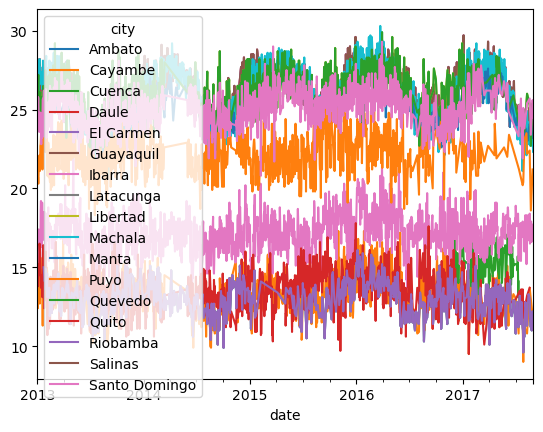

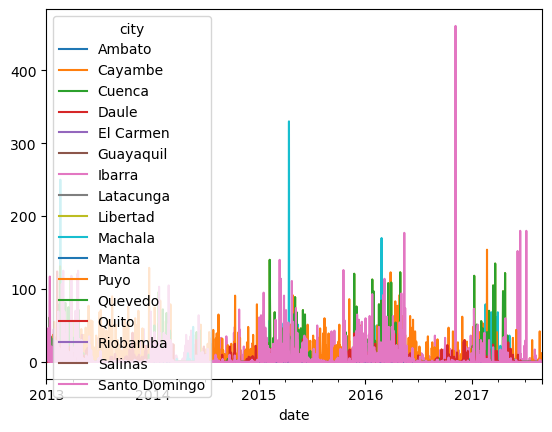

In [263]:
df_weather[['date', 'city', 'tavg']].pivot(columns='city', index='date', values='tavg').plot()
df_weather[['date', 'city', 'prcp']].pivot(columns='city', index='date', values='prcp').plot()

In [264]:
# convert to timestamp and remove leading 0s
df_train_partial.date = pd.to_datetime(df_train_partial.date)
df_test_partial.date = pd.to_datetime(df_test_partial.date)
df_train_partial = df_train_partial.sort_values(['store_nbr', 'family', 'date']).groupby(['store_nbr', 'family']).apply(lambda x: x[x.sales.cumsum()>0]).reset_index(drop=True)

**Cleaning Oil Data**
* Linearly interpolate weekends
* Add 7-day and 30-day moving averages
* Add 7-day and 30-day rolling max

In [265]:
df_oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
df_oil = df_oil.set_index('date')
df_oil.index = pd.to_datetime(df_oil.index)
df_oil = df_oil.resample('D').first().interpolate(method='linear').bfill() #  fill first value
df_oil = df_oil.rename({'dcoilwtico': 'price'}, axis=1)
df_oil['price_7d_ma'] = df_oil.price.rolling(7).mean().bfill()
df_oil['price_30d_ma'] = df_oil.price.rolling(30).mean().bfill()
df_oil['price_7d_max'] = df_oil.price.rolling(7).max().bfill()
df_oil['price_30d_max'] = df_oil.price.rolling(30).max().bfill()
df_oil['price_7d_min'] = df_oil.price.rolling(7).min().bfill()
df_oil['price_30d_min'] = df_oil.price.rolling(30).min().bfill()

**Cleaning Holiday Data**
* Holidays such as Navidad-1, -2, -3 etc are all cleaned to Navidad, as it might be an important feature
* Splitting holiday types into different dataframes (national, regional, local)

In [266]:
def clean_hol(x):
    if ':' in x:
        x = x.split(':')[0]
    if '-' in x:
        x = x.split('-')[0]
    if '+' in x:
        x = x.split('+')[0]
        
    if 'Cantonizacion' in x:
        x = 'Cantonizacion'
    if 'Provincializacion' in x:
        x = 'Provincializacion'
    if 'Navidad' in x:
        x = 'Navidad'
    if 'Fundacion' in x:
        x = 'Fundacion'
        
    return x.strip('Puente').lower()

df_hols = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
df_hols['holiday_description_clean'] = df_hols.description.apply(clean_hol)
df_hols = df_hols[~df_hols.transferred].drop(['transferred'], axis=1)
df_hols = df_hols.rename(
    {'type': 'holiday_type', 
     'description': 'holiday_description'
    }, axis=1)
df_hols.date = pd.to_datetime(df_hols.date)
    
holiday_loc = df_hols[df_hols.locale == 'Local']
holiday_reg = df_hols[df_hols.locale == 'Regional']
holiday_nat = df_hols[df_hols.locale == 'National']

holiday_loc = holiday_loc.rename(columns={'locale_name': 'city' })
holiday_reg = holiday_reg.rename(columns={'locale_name': 'state'})

In [267]:
df_stores = df_stores.rename({'type': 'store_type',}, axis=1)

**Calendar DataFrame**
* Describing features of each day such as:
    * does it fall on a weekend?
    * what day of week is it?
    * what month is it? etc

In [268]:
min_date = df_train_partial.date.min()
max_date = df_test_partial.date.max()
df_cal = pd.DataFrame(index=pd.date_range(min_date, max_date))
df_cal['day_of_week'] = df_cal.index.map(dt.isoweekday)
df_cal['is_weekend'] = df_cal.day_of_week >= 5
df_cal['month_of_year'] = df_cal.index.map(lambda x: x.month)
df_cal['day_of_year'] = df_cal.index.map(lambda x: x.timetuple().tm_yday)
df_cal['week_of_year'] = df_cal.day_of_year//7+1
df_cal['day_of_month'] = df_cal.index.map(lambda x: x.day)
df_cal['is_wage_day'] = df_cal.index.map(lambda x: x.day in [15, calendar.monthrange(x.year, x.month)[1]])
df_cal['is_wage_day_after'] = df_cal.is_wage_day.shift().fillna(False)

In [269]:
n = 3
print('-'*10, 'Oil Prices', '-'*10)
print(df_oil.head(n))
print('-'*10, 'Calendar', '-'*10)
print(df_cal.head(n))
print('-'*10, 'Holidays', '-'*10)
print(df_hols.head(n))
print('-'*10, 'Stores', '-'*10)
print(df_stores.head(n))
print('-'*10, 'Training data', '-'*10)
print(df_train_partial.head(n))
print('-'*10, 'Test data', '-'*10)
print(df_test_partial.head(n))
print('-'*10, 'Transactions', '-'*10)
print(df_transactions.head(n))
print('-'*10, 'Weather', '-'*10)
print(df_weather.head(n))

---------- Oil Prices ----------
            price  price_7d_ma  price_30d_ma  price_7d_max  price_30d_max  \
date                                                                        
2013-01-01  93.14    93.127143     94.607333          93.2          97.98   
2013-01-02  93.14    93.127143     94.607333          93.2          97.98   
2013-01-03  92.97    93.127143     94.607333          93.2          97.98   

            price_7d_min  price_30d_min  
date                                     
2013-01-01         92.97          92.97  
2013-01-02         92.97          92.97  
2013-01-03         92.97          92.97  
---------- Calendar ----------
            day_of_week  is_weekend  month_of_year  day_of_year  week_of_year  \
2013-01-01            2       False              1            1             1   
2013-01-02            3       False              1            2             1   
2013-01-03            4       False              1            3             1   

            day

<Axes: xlabel='date'>

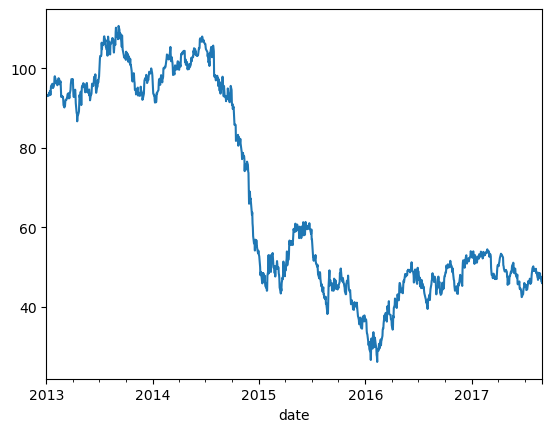

In [270]:
df_oil['price'].plot()

In [271]:
def preprocess(df_in, label_encoder_map=None):
    print('merging...')
    df_out = df_in\
        .merge(df_stores, how='inner', on='store_nbr')\
        .merge(df_oil, how='inner', on='date')\
        .merge(df_weather, how='left', on=['date', 'city'])\
        .merge(df_cal, how='inner', left_on='date', right_index=True).copy()


    df_out_loc = pd.merge(df_out, holiday_loc, on=['date', 'city'], how='left')
    df_out_loc = df_out_loc[~(df_out_loc.holiday_type == 'Holiday')]
    
    df_out_reg = pd.merge(df_out, holiday_reg, on=['date', 'state'], how='left')
    df_out_reg = df_out_reg[~(df_out_reg.holiday_type == 'Holiday')]
    
    df_out_nat = pd.merge(df_out, holiday_nat, on=['date'], how='left') 
    df_out_nat = df_out_nat[~(df_out_nat.holiday_type == 'Holiday')]
    
    df_out = pd.concat([df_out_loc, df_out_reg, df_out_nat])
    

    df_out = df_out[~df_out.id.duplicated(keep='first')]
    df_out = df_out.drop(['locale', 'locale_name'], axis=1, errors='ignore')
    
    print(df_out.head(50))
    
    col_encode = [
        'family',
        'holiday_type',
        'holiday_description',
        'holiday_description_clean',
        'city',
        'state',
        'store_type',
    ]
    
    scaler = None
    if 'sales' in df_out:
        print('Scaling...')
#         scaler = MinMaxScaler()
#         scaler = PowerTransformer(method='box-cox', standardize=False)
        scaler = PowerTransformer(method='yeo-johnson', standardize=False)
#         scaler = QuantileTransformer(output_distribution='normal', random_state=0)
#         scaler = StandardScaler()
        df_out['sales_transformed'] = scaler.fit_transform(np.array(df_out.sales).reshape(-1, 1))
    
    print('computing label encoding...')
    if label_encoder_map is None:
        label_encoder_map = {}
        for col in col_encode:
            if col not in df_out: continue
            le = preprocessing.LabelEncoder()
            df_out[col] = le.fit_transform(df_out[col])
            label_encoder_map[col] = le
    else:
        for col in col_encode:
            if col not in df_out: continue
            le = label_encoder_map[col]
            df_out[col] = le.transform(df_out[col])
            
    assert df_in.shape[0] == df_out.shape[0]
    return df_out, label_encoder_map, scaler  # should fillna only to specific columns!

df_train, label_encoder_map, scaler = preprocess(df_train_partial)
print(df_train.columns)

merging...
      id       date  store_nbr            family        sales  onpromotion  \
0   1782 2013-01-02          1        AUTOMOTIVE     2.000000            0   
1   1784 2013-01-02          1            BEAUTY     2.000000            0   
2   1785 2013-01-02          1         BEVERAGES  1091.000000            0   
3   1787 2013-01-02          1      BREAD/BAKERY   470.652000            0   
4   1789 2013-01-02          1          CLEANING  1060.000000            0   
5   1790 2013-01-02          1             DAIRY   579.000000            0   
6   1791 2013-01-02          1              DELI   164.069000            0   
7   1792 2013-01-02          1              EGGS   246.000000            0   
8   1793 2013-01-02          1      FROZEN FOODS   131.000000            0   
9   1794 2013-01-02          1         GROCERY I  2652.000000            0   
10  1795 2013-01-02          1        GROCERY II    31.000000            0   
11  1796 2013-01-02          1          HARDWARE     

<Axes: title={'center': 'sales'}, xlabel='holiday_description_clean'>

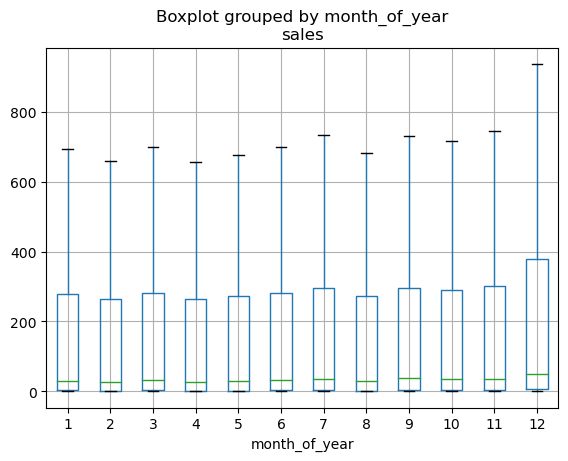

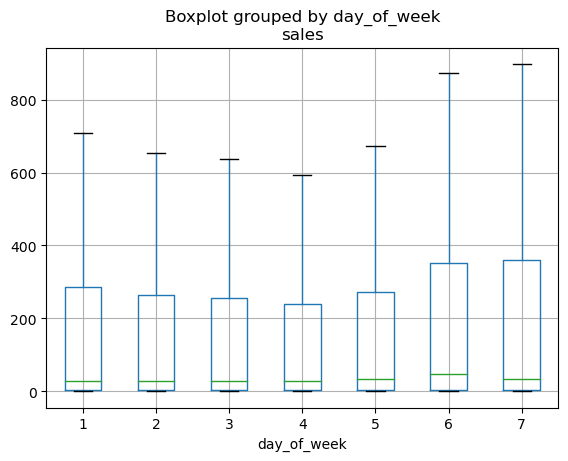

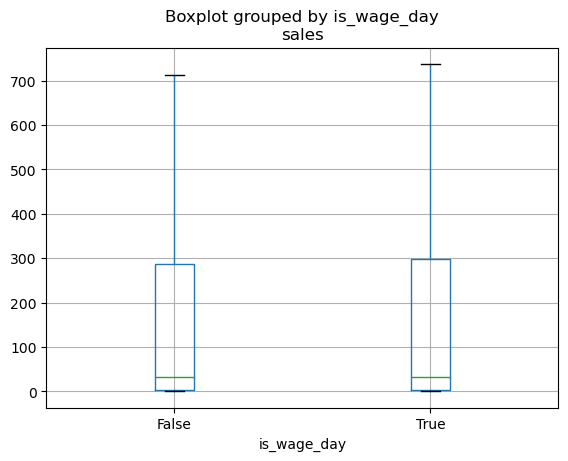

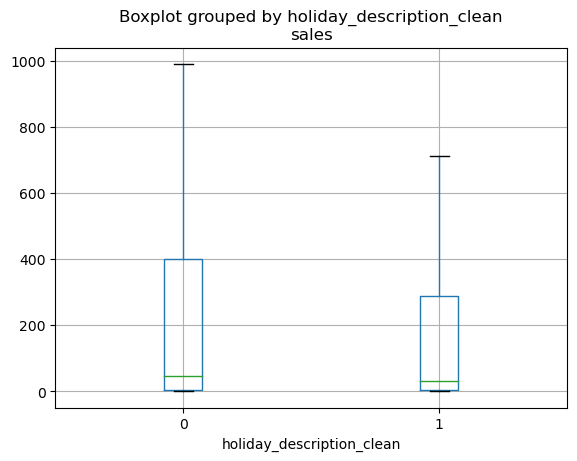

In [272]:
df_train.boxplot(column='sales', by='month_of_year', showfliers=False)
df_train.boxplot(column='sales', by='day_of_week', showfliers=False)
df_train.boxplot(column='sales', by='is_wage_day', showfliers=False)
df_train.boxplot(column='sales', by='holiday_description_clean', showfliers=False)

<Axes: xlabel='prcp', ylabel='sales'>

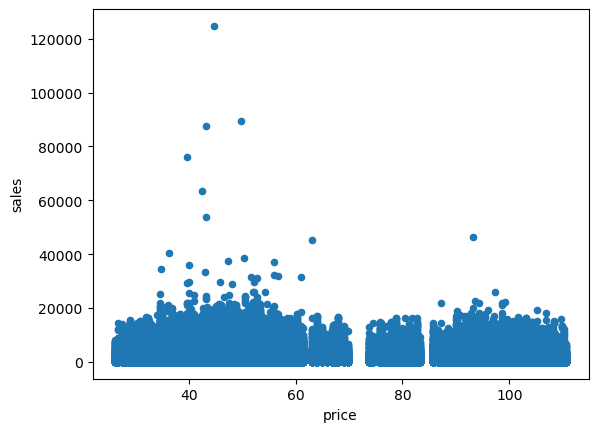

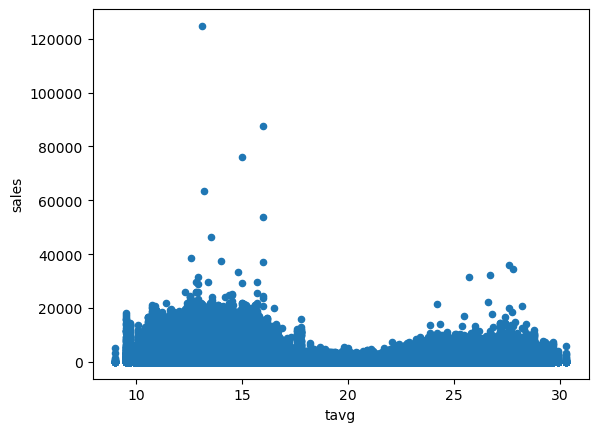

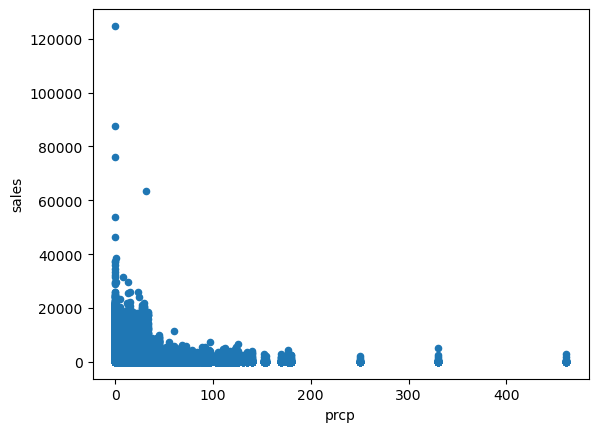

In [273]:
df_train[['price', 'sales']].plot.scatter(x='price', y='sales')
df_train[['tavg', 'sales']].plot.scatter(x='tavg', y='sales')
df_train[['prcp', 'sales']].plot.scatter(x='prcp', y='sales')

In [274]:
df_train = df_train.sort_values(['store_nbr', 'family', 'date'])

<Axes: >

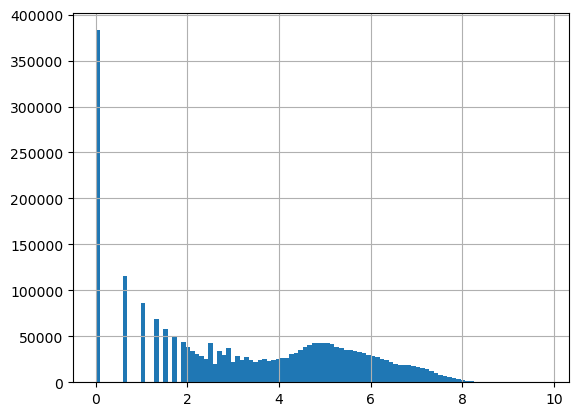

In [275]:
df_train.sales_transformed.hist(bins=100)

In [276]:
corr_matrix = df_train.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,price,price_7d_ma,price_30d_ma,price_7d_max,price_30d_max,price_7d_min,price_30d_min,tavg,tmin,tmax,prcp,tavg_ma7,prcp_ma7,day_of_week,is_weekend,month_of_year,day_of_year,week_of_year,day_of_month,is_wage_day,is_wage_day_after,holiday_type,holiday_description,holiday_description_clean,sales_transformed
id,1.000000,0.012992,0.030270,0.036253,0.198075,0.006041,-0.003664,0.015515,-0.014736,-0.817397,-0.818783,-0.824594,-0.823294,-0.835867,-0.814266,-0.811657,0.035662,0.048395,0.038176,-0.007809,0.043325,-0.138322,-0.002669,-0.002025,0.051948,0.053217,0.053257,0.002745,0.003487,-0.000723,-0.008749,-0.014925,-0.009399,0.012340
store_nbr,0.012992,1.000000,0.002174,0.060037,0.017163,-0.320501,-0.203929,-0.412796,-0.074281,-0.009935,-0.009886,-0.009738,-0.009897,-0.009751,-0.009869,-0.009711,0.327055,0.322947,0.313038,-0.060136,0.327508,0.194108,0.000012,0.000024,0.002453,0.002445,0.002445,0.000061,0.000046,-0.000027,0.003776,-0.002484,0.003296,0.040044
family,0.030270,0.002174,1.000000,-0.141874,-0.059490,0.003795,0.006691,-0.003727,0.008884,-0.031051,-0.030880,-0.030258,-0.030715,-0.029767,-0.030976,-0.030605,-0.007267,-0.008142,-0.006893,-0.000559,-0.007305,-0.002621,-0.000022,-0.000006,0.001110,0.001151,0.001151,0.000099,-0.000047,0.000030,-0.000024,0.000127,-0.000014,-0.138402
sales,0.036253,0.060037,-0.141874,1.000000,0.419392,0.058494,0.077423,-0.112970,0.036900,-0.031459,-0.031225,-0.030609,-0.031182,-0.030944,-0.031356,-0.030386,-0.087957,-0.096084,-0.084808,0.005218,-0.089169,-0.041527,0.041207,0.043418,0.020578,0.019380,0.019185,-0.013828,0.001119,0.007129,-0.003919,-0.001392,-0.003869,0.553519
onpromotion,0.198075,0.017163,-0.059490,0.419392,1.000000,0.007209,0.014569,-0.012235,0.002559,-0.142015,-0.142547,-0.144866,-0.143992,-0.147876,-0.141406,-0.142011,-0.003945,-0.002624,-0.001905,-0.003769,-0.002465,-0.039894,-0.003091,-0.000392,0.027823,0.028272,0.028172,0.002138,0.002828,-0.001185,-0.002854,-0.002938,-0.002932,0.315497
city,0.006041,-0.320501,0.003795,0.058494,0.007209,1.000000,0.483648,-0.083821,0.092464,-0.005939,-0.005936,-0.005954,-0.005972,-0.006029,-0.005908,-0.005876,-0.313594,-0.388736,-0.276353,0.142643,-0.318676,-0.100167,-0.000019,-0.000020,0.000180,0.000182,0.000183,-0.000066,0.000038,0.000032,-0.010289,0.003878,-0.009346,0.051965
state,-0.003664,-0.203929,0.006691,0.077423,0.014569,0.483648,1.000000,-0.233032,0.163249,0.003102,0.003132,0.003224,0.003128,0.003247,0.003126,0.003185,-0.437978,-0.471642,-0.414126,0.108400,-0.445391,-0.478364,0.000001,-0.000002,-0.000977,-0.000997,-0.000997,-0.000101,0.000019,0.000029,-0.008107,0.006184,-0.006853,0.080080
store_type,0.015515,-0.412796,-0.003727,-0.112970,-0.012235,-0.083821,-0.233032,1.000000,-0.278951,-0.015220,-0.015234,-0.015294,-0.015232,-0.015345,-0.015218,-0.015245,0.321372,0.322986,0.316586,-0.005343,0.326539,0.134589,-0.000068,-0.000059,0.004735,0.004776,0.004776,0.000210,0.000019,0.000089,0.005480,0.000317,0.005263,-0.075634
cluster,-0.014736,-0.074281,0.008884,0.036900,0.002559,0.092464,0.163249,-0.278951,1.000000,0.012680,0.012817,0.013312,0.012955,0.013721,0.012693,0.012865,-0.515149,-0.497708,-0.505685,-0.013633,-0.519190,-0.338209,0.000037,0.000027,-0.000066,-0.000125,-0.000126,-0.000086,-0.000023,0.000011,-0.008274,-0.000111,-0.007570,0.025172
price,-0.817397,-0.009935,-0.031051,-0.031459,-0.142015,-0.005939,0.003102,-0.015220,0.012680,1.000000,0.998626,0.992139,0.998266,0.989082,0.998411,0.992942,-0.067401,-0.071504,-0.067268,-0.041467,-0.075285,0.039949,0.002433,0.002321,0.005475,0.003470,0.003445,-0.001022,-0.001599,0.000248,0.003796,0.004228,0.003995,-0.017024


In [277]:
corr_matrix.loc['sales_transformed'].abs().sort_values()

holiday_description          0.002101
is_wage_day                  0.002614
day_of_month                 0.004291
holiday_type                 0.004777
holiday_description_clean    0.004778
is_wage_day_after            0.005451
prcp                         0.007478
id                           0.012340
price_30d_min                0.015373
price_30d_ma                 0.015568
price_30d_max                0.016376
price_7d_ma                  0.016775
price_7d_max                 0.016828
price_7d_min                 0.016930
price                        0.017024
cluster                      0.025172
day_of_week                  0.029216
is_weekend                   0.034203
week_of_year                 0.038771
day_of_year                  0.038868
month_of_year                0.039338
store_nbr                    0.040044
prcp_ma7                     0.042910
city                         0.051965
store_type                   0.075634
state                        0.080080
tmax        

In [278]:
models = {}
for fam in df_train.family.unique():
    fam_clean = label_encoder_map['family'].inverse_transform([fam])[0]
    print(f'{fam}) Training {fam_clean}...')
    df_train_fam = df_train[df_train.family==fam]
    X_train = df_train_fam.drop(['sales', 'date', 'sales_transformed', 'id'], axis=1, errors='ignore')
    y_train = df_train_fam.sales_transformed
    clf = lgb.LGBMRegressor()
    clf.fit(X_train, y_train)
    models[fam] = clf

0) Training AUTOMOTIVE...
2) Training BEAUTY...
3) Training BEVERAGES...
4) Training BOOKS...
5) Training BREAD/BAKERY...
6) Training CELEBRATION...
7) Training CLEANING...
8) Training DAIRY...
9) Training DELI...
10) Training EGGS...
11) Training FROZEN FOODS...
12) Training GROCERY I...
13) Training GROCERY II...
14) Training HARDWARE...
15) Training HOME AND KITCHEN I...
16) Training HOME AND KITCHEN II...
17) Training HOME APPLIANCES...
18) Training HOME CARE...
19) Training LADIESWEAR...
20) Training LAWN AND GARDEN...
21) Training LINGERIE...
22) Training LIQUOR,WINE,BEER...
23) Training MAGAZINES...
24) Training MEATS...
25) Training PERSONAL CARE...
26) Training PET SUPPLIES...
27) Training PLAYERS AND ELECTRONICS...
28) Training POULTRY...
29) Training PREPARED FOODS...
30) Training PRODUCE...
31) Training SCHOOL AND OFFICE SUPPLIES...
32) Training SEAFOOD...
1) Training BABY CARE...


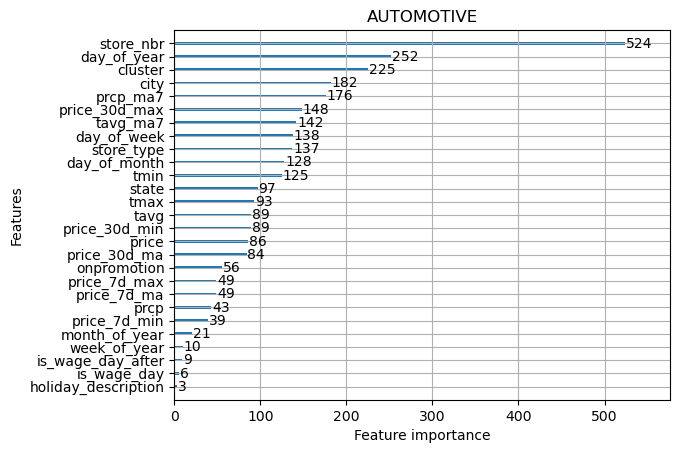

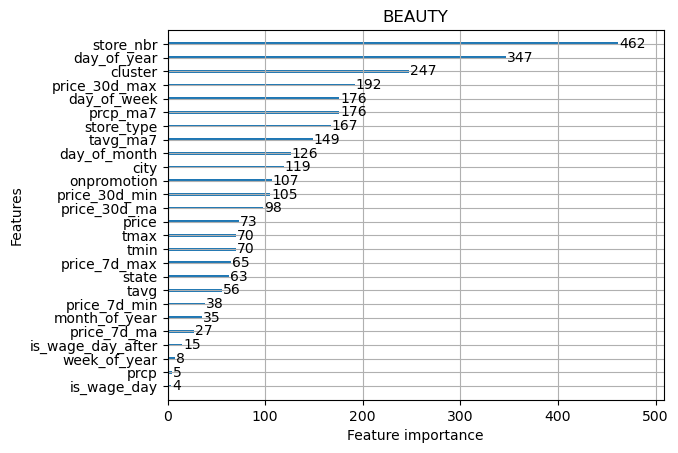

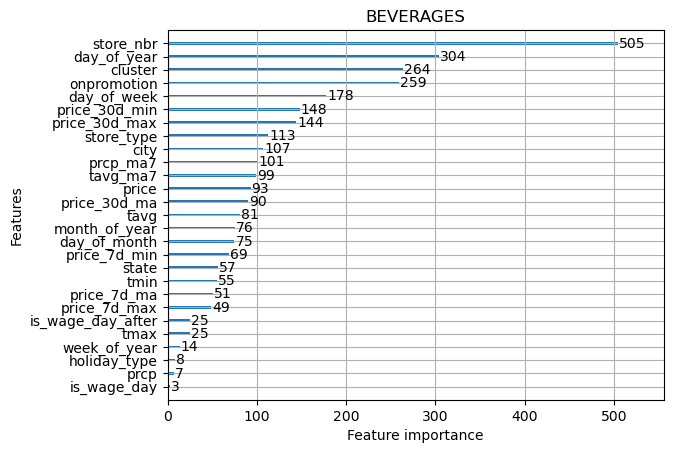

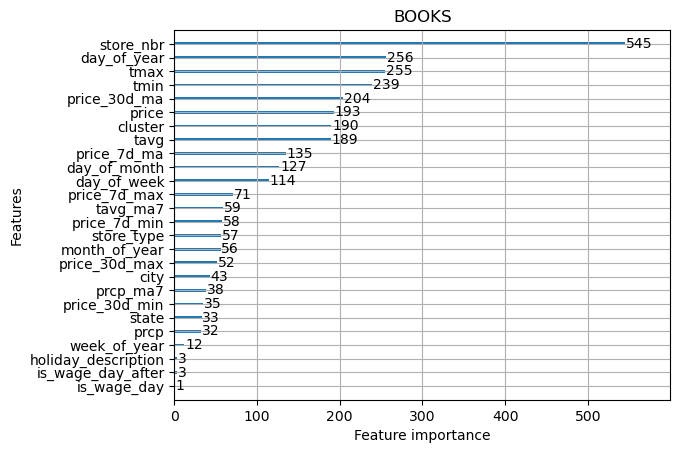

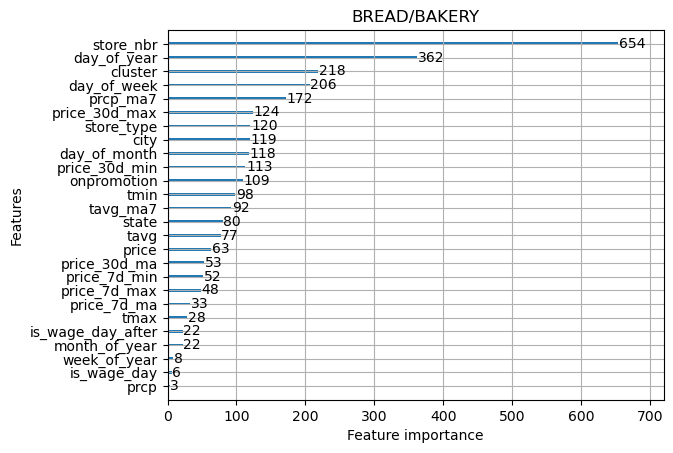

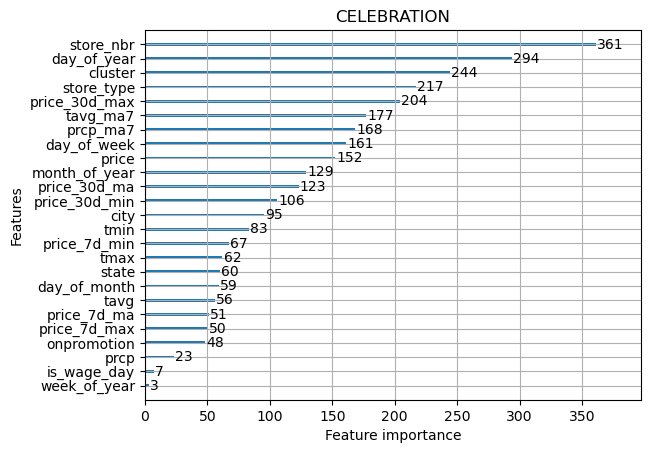

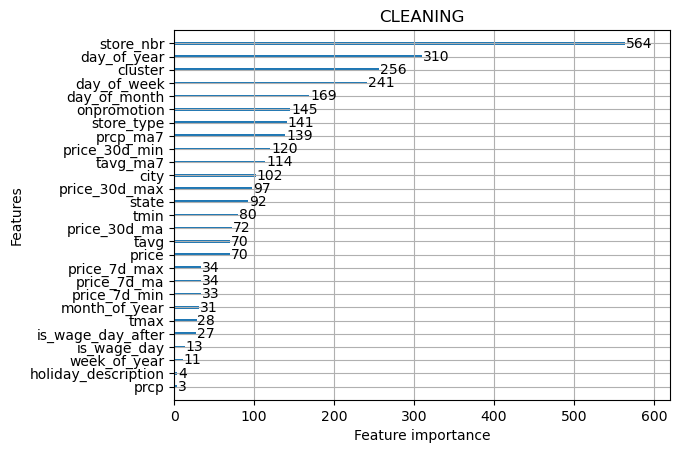

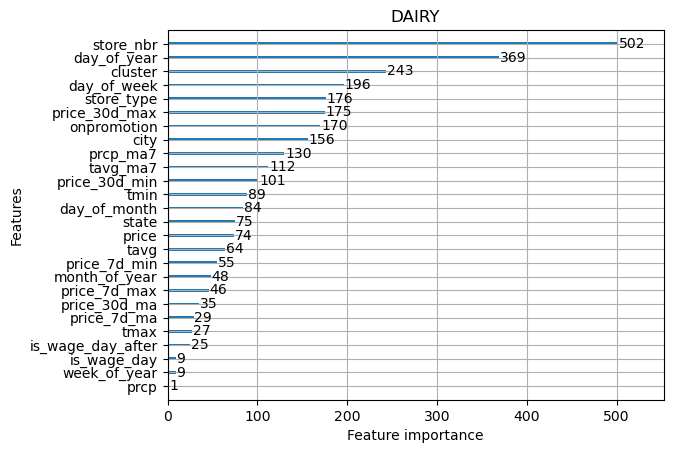

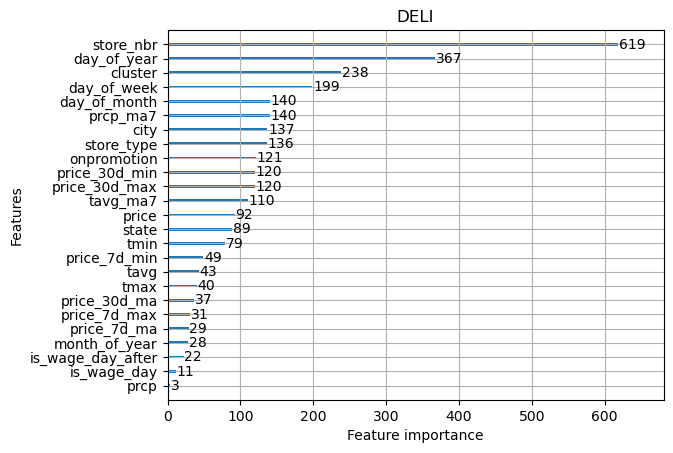

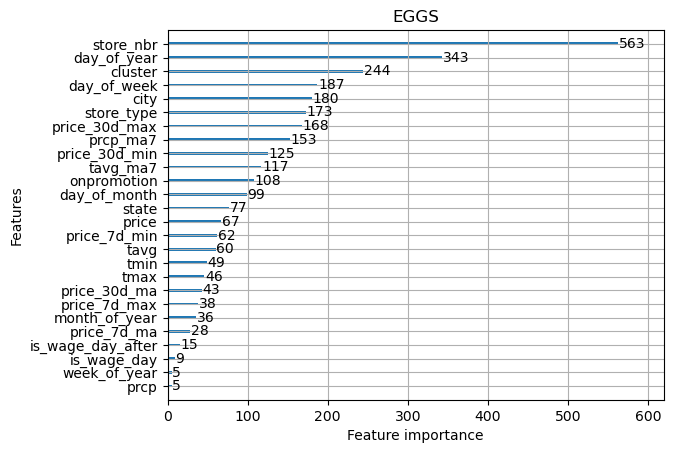

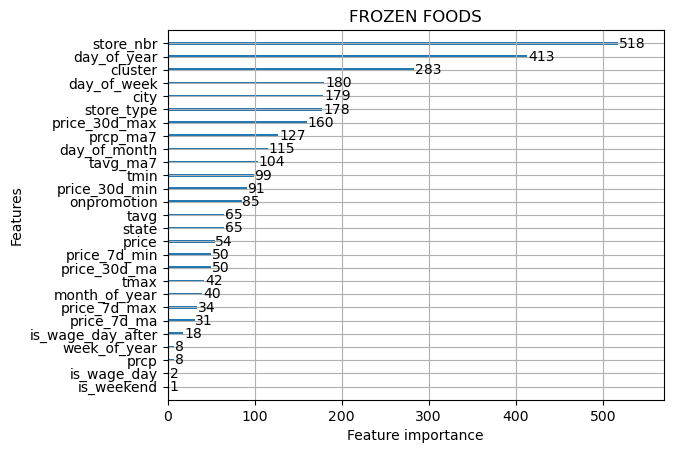

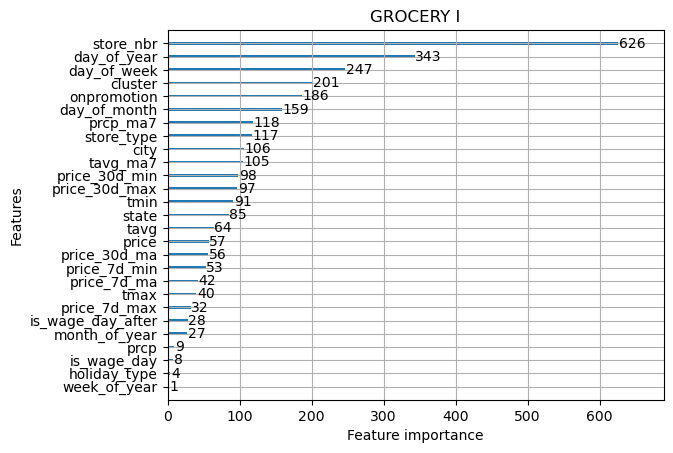

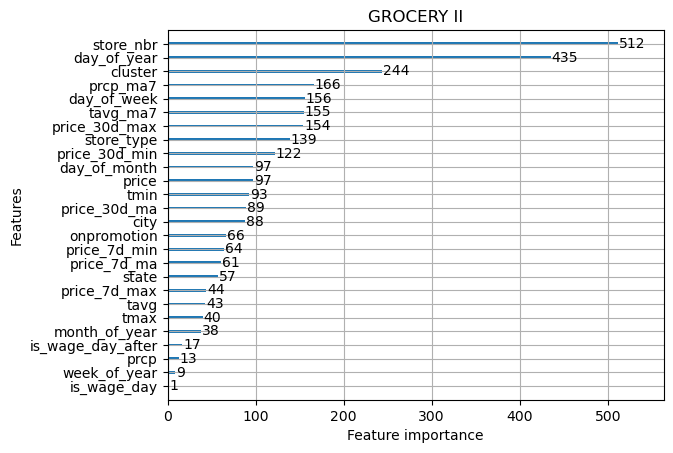

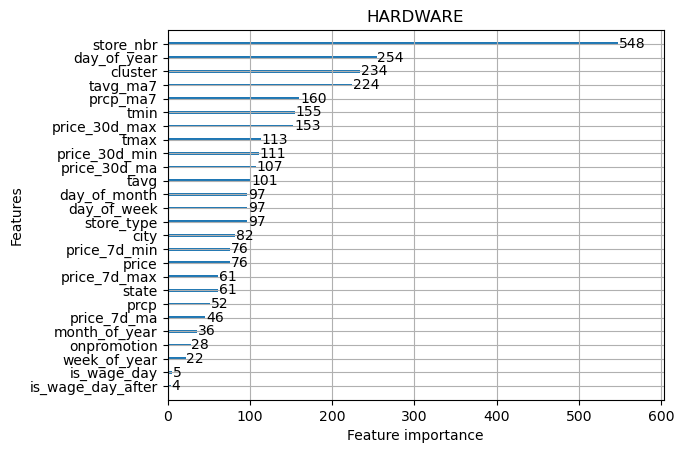

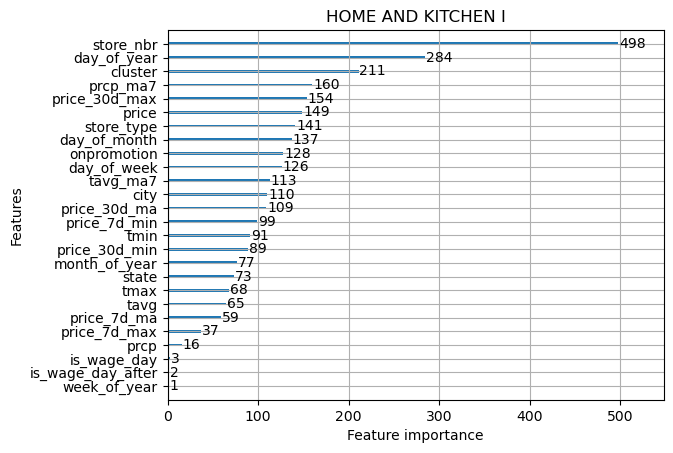

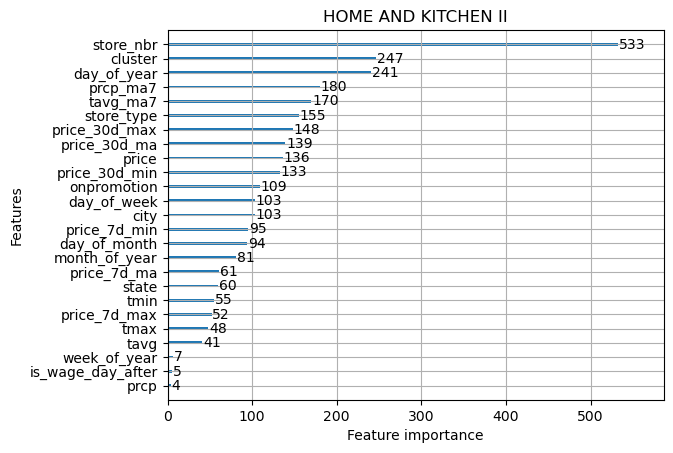

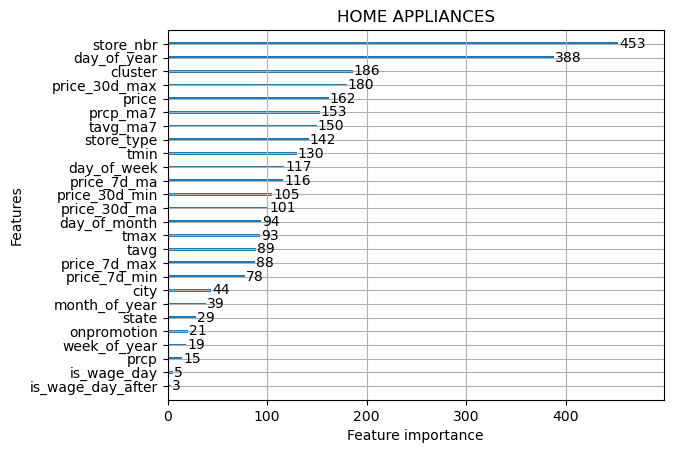

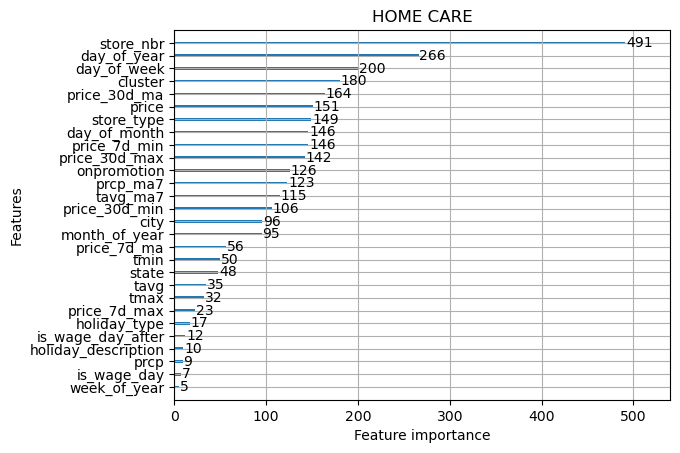

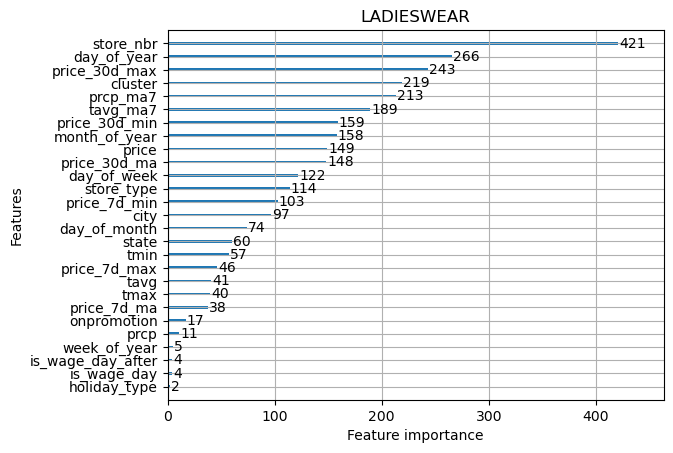

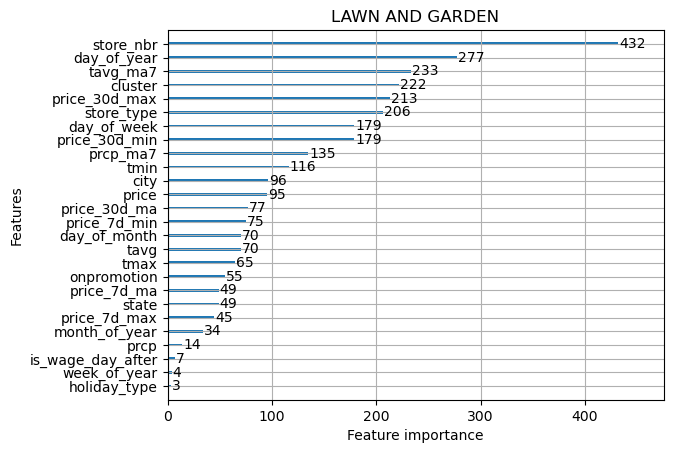

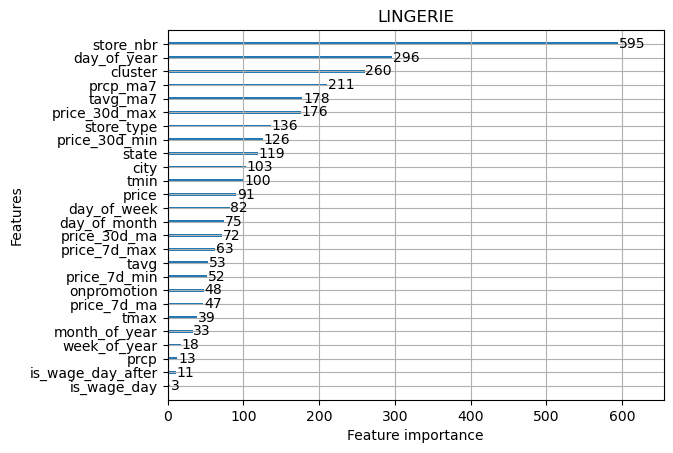

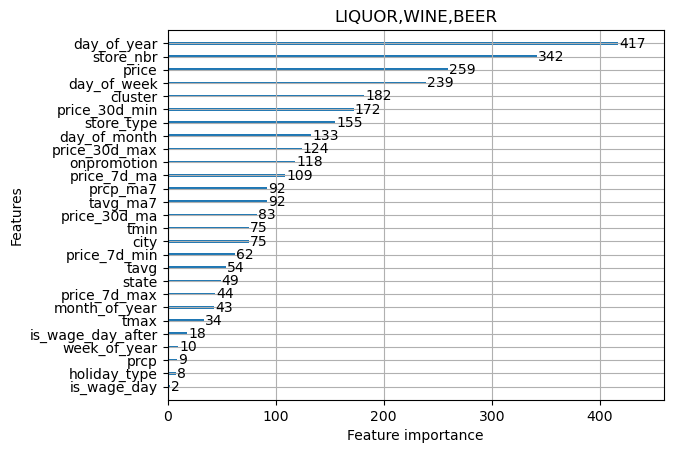

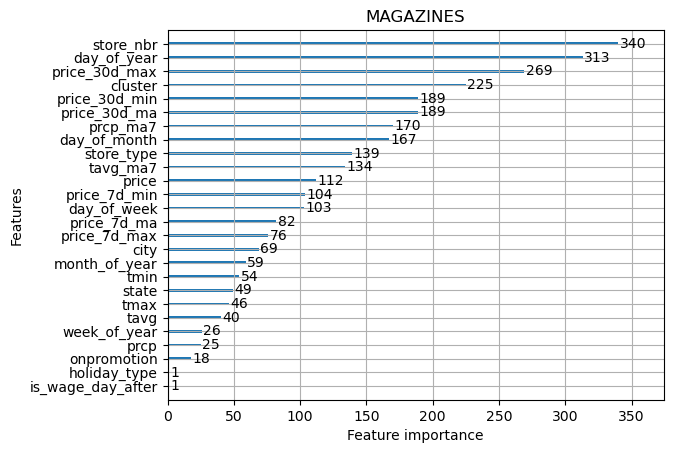

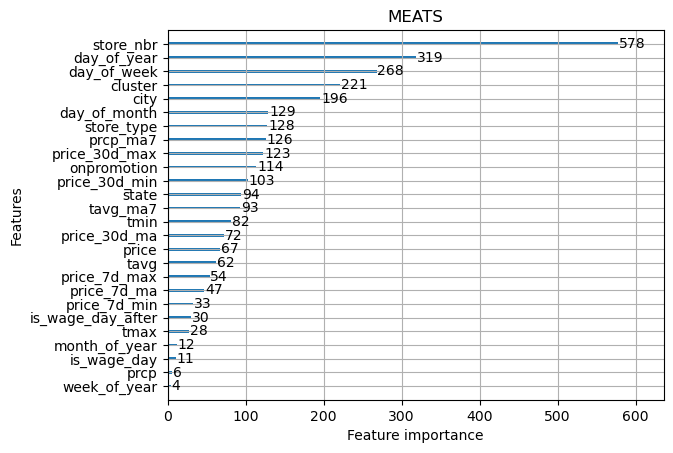

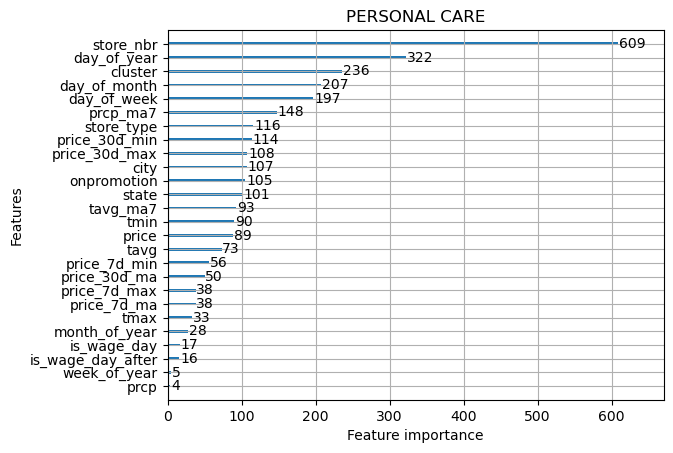

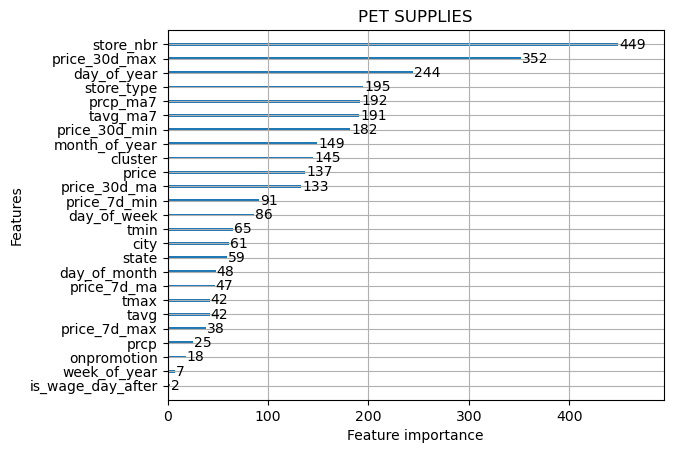

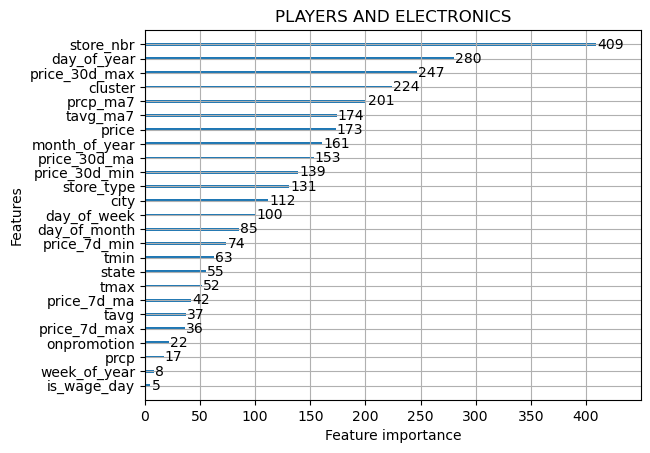

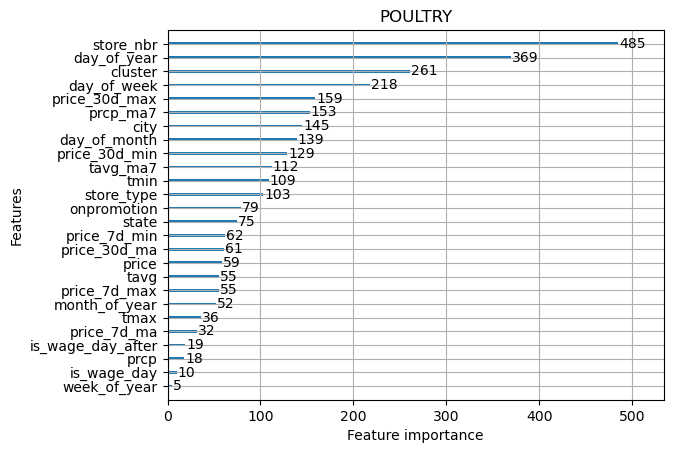

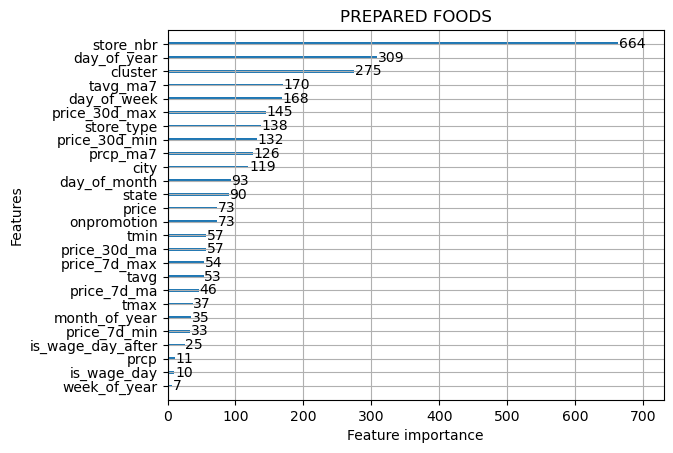

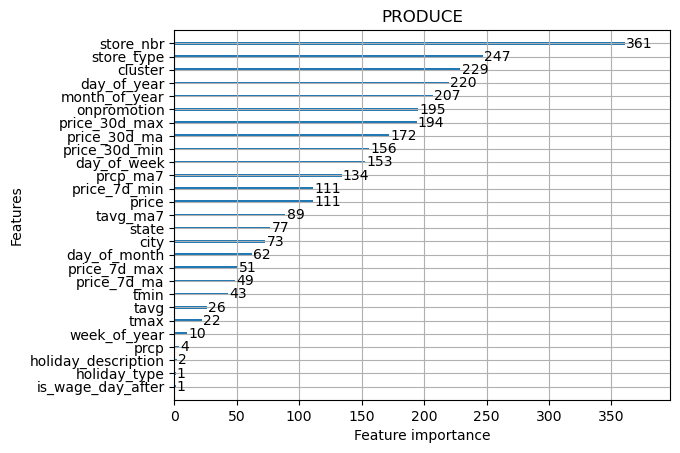

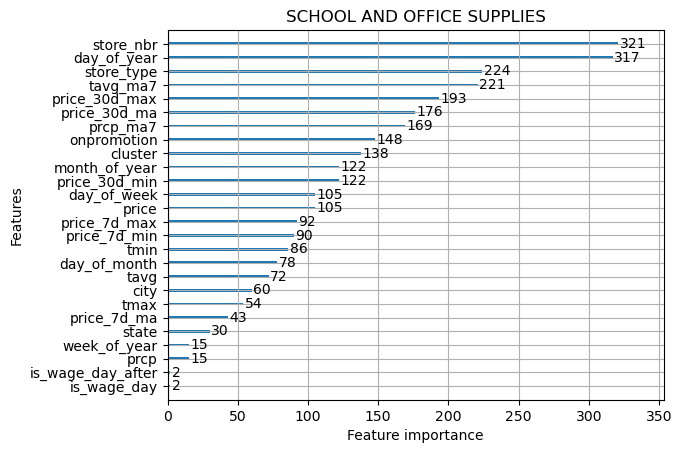

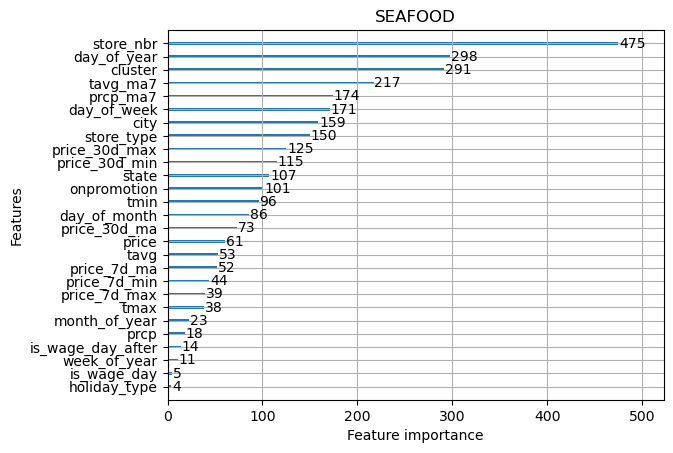

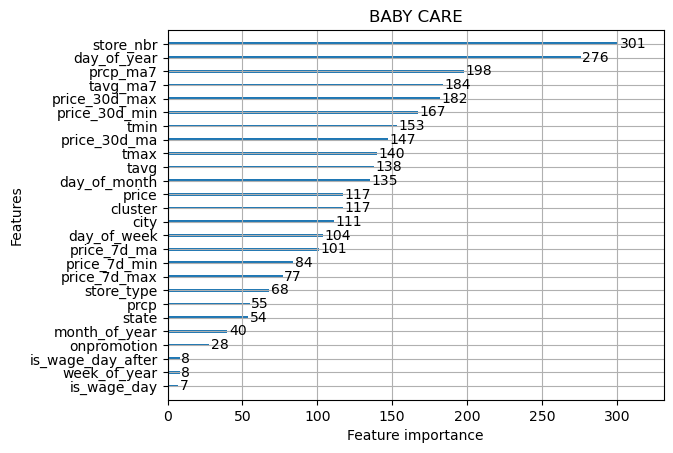

In [279]:
for fam, clf in models.items():
    fam_clean = label_encoder_map['family'].inverse_transform([fam])[0]
    lgb.plot_importance(clf, title=fam_clean)
    plt.show()
    plt.close()

In [280]:
df_train['sales_pred'] = np.nan
for fam, clf in models.items():
    X_train = df_train[df_train.family==fam].drop(['sales', 'date', 'sales_transformed', 'id', 'sales_pred'], axis=1, errors='ignore')
    df_train.loc[df_train.family == fam, 'sales_pred'] = clf.predict(X_train)

In [281]:
df_train

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,day_of_year,week_of_year,day_of_month,is_wage_day,is_wage_day_after,holiday_type,holiday_description,holiday_description_clean,sales_transformed,sales_pred
0,1782,2013-01-02,1,0,2.0,0,18,12,3,13,...,2,1,2,False,False,2,4,1,1.080042,1.359009
864,3564,2013-01-03,1,0,3.0,0,18,12,3,13,...,3,1,3,False,False,2,4,1,1.356813,1.070870
1755,5346,2013-01-04,1,0,3.0,0,18,12,3,13,...,4,1,4,False,False,2,4,1,1.356813,1.043892
2657,7128,2013-01-05,1,0,5.0,0,18,12,3,13,...,5,1,5,False,False,2,4,1,1.742716,1.079218
3567,8910,2013-01-06,1,0,2.0,0,18,12,3,13,...,6,1,6,False,False,2,4,1,1.080042,0.631584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437996,2993627,2017-08-11,54,32,0.0,0,5,10,2,3,...,223,32,11,False,False,2,4,1,-0.000000,0.585418
2439725,2995409,2017-08-12,54,32,1.0,1,5,10,2,3,...,224,33,12,False,False,2,4,1,0.685724,1.201529
2441454,2997191,2017-08-13,54,32,2.0,0,5,10,2,3,...,225,33,13,False,False,2,4,1,1.080042,0.833934
2443183,2998973,2017-08-14,54,32,0.0,0,5,10,2,3,...,226,33,14,False,False,2,4,1,-0.000000,0.716534


In [282]:
df_train[['date', 'family', 'sales_transformed', 'store_nbr']].pivot(index='date', columns=['store_nbr', 'family'], values='sales_transformed')
df_train['sales_pred_inv'] = scaler.inverse_transform(df_train.sales_pred.values.reshape(-1, 1))
df_train.sales_pred_inv = df_train.sales_pred_inv.clip(lower=0)
df_train

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,week_of_year,day_of_month,is_wage_day,is_wage_day_after,holiday_type,holiday_description,holiday_description_clean,sales_transformed,sales_pred,sales_pred_inv
0,1782,2013-01-02,1,0,2.0,0,18,12,3,13,...,1,2,False,False,2,4,1,1.080042,1.359009,3.009180
864,3564,2013-01-03,1,0,3.0,0,18,12,3,13,...,1,3,False,False,2,4,1,1.356813,1.070870,1.971666
1755,5346,2013-01-04,1,0,3.0,0,18,12,3,13,...,1,4,False,False,2,4,1,1.356813,1.043892,1.889912
2657,7128,2013-01-05,1,0,5.0,0,18,12,3,13,...,1,5,False,False,2,4,1,1.742716,1.079218,1.997443
3567,8910,2013-01-06,1,0,2.0,0,18,12,3,13,...,1,6,False,False,2,4,1,1.080042,0.631584,0.892453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437996,2993627,2017-08-11,54,32,0.0,0,5,10,2,3,...,32,11,False,False,2,4,1,-0.000000,0.585418,0.805462
2439725,2995409,2017-08-12,54,32,1.0,1,5,10,2,3,...,33,12,False,False,2,4,1,0.685724,1.201529,2.402708
2441454,2997191,2017-08-13,54,32,2.0,0,5,10,2,3,...,33,13,False,False,2,4,1,1.080042,0.833934,1.327856
2443183,2998973,2017-08-14,54,32,0.0,0,5,10,2,3,...,33,14,False,False,2,4,1,-0.000000,0.716534,1.063997


In [283]:
df_agg = df_train[['date', 'family', 'store_nbr', 'sales']].pivot_table(index='date', columns='store_nbr', values='sales', aggfunc='sum')
df_agg_pred = df_train[['date', 'family', 'sales_pred_inv', 'store_nbr']].pivot_table(index='date', columns='store_nbr', values='sales_pred_inv', aggfunc='sum')

Text(0.5, 1.0, 'Store Number: 4')

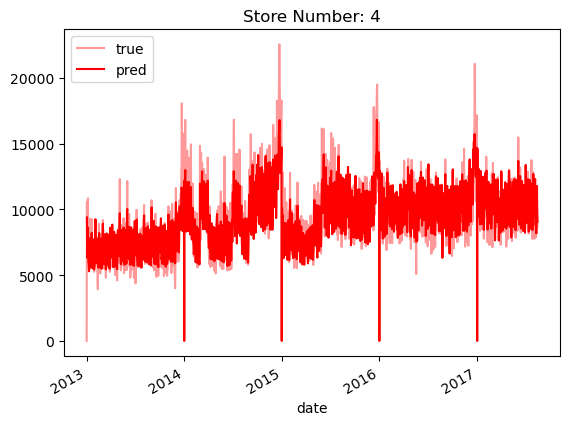

In [284]:
lookback = -20000
store_num = 4

ax = df_agg.fillna(0).iloc[lookback:,store_num:store_num+1].plot(alpha=0.4, color='r')
df_agg_pred.iloc[lookback:,store_num:store_num+1].plot(ax=ax, color='r')
ax.legend(['true', 'pred'])
ax.set_title(f'Store Number: {store_num}')

**Running model on test data**

In [285]:
df_test, _, _ = preprocess(df_test_partial, label_encoder_map)
df_test['sales'] = np.nan
for fam in df_test.family.unique():
    clf = models[fam]
    X_test = df_test[df_test.family==fam].drop(['date', 'date_timestamp', 'transactions', 'id', 'sales'], axis=1, errors='ignore')
    df_test.loc[df_test.family==fam, 'sales'] = scaler.inverse_transform(clf.predict(X_test).reshape(-1, 1))
    

df_test.sales = df_test.sales.clip(lower=0)

merging...
         id       date  store_nbr                      family  onpromotion  \
0   3000888 2017-08-16          1                  AUTOMOTIVE            0   
1   3000889 2017-08-16          1                   BABY CARE            0   
2   3000890 2017-08-16          1                      BEAUTY            2   
3   3000891 2017-08-16          1                   BEVERAGES           20   
4   3000892 2017-08-16          1                       BOOKS            0   
5   3000893 2017-08-16          1                BREAD/BAKERY           12   
6   3000894 2017-08-16          1                 CELEBRATION            0   
7   3000895 2017-08-16          1                    CLEANING           25   
8   3000896 2017-08-16          1                       DAIRY           45   
9   3000897 2017-08-16          1                        DELI           18   
10  3000898 2017-08-16          1                        EGGS            1   
11  3000899 2017-08-16          1                FROZ

Text(0.5, 1.0, 'BEAUTY')

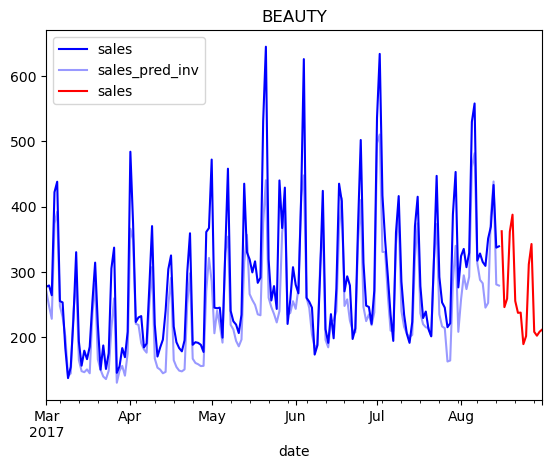

In [286]:
fam = 2
fam_clean = label_encoder_map['family'].inverse_transform([fam])[0]
start = '2017-03-01'
ax = df_train[(df_train.family==fam)&(df_train.date>=start)][['date', 'sales']].groupby('date').sum().plot(color='b')
df_train[(df_train.family==fam)&(df_train.date>=start)][['date', 'sales_pred_inv']].groupby('date').sum().plot(alpha=0.4, color='b', ax=ax)
df_test[df_test.family==fam][['date', 'sales']].groupby('date').sum().plot(ax=ax, color='r')
ax.set_title(fam_clean)

Competition evaluation uses RMSLE:

$\text{RMSLE} = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}$

In [287]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: {}%'.format(round(explained_variance*100,2)))    
    print('R2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print()
    print('RMSLE: ', round(np.sqrt(mean_squared_log_error),4))
    
regression_results(df_train.sales, df_train.sales_pred_inv)

explained_variance: 93.92%
R2:  0.9389
MAE:  67.8715
MSE:  88896.9556
RMSE:  298.1559

RMSLE:  0.4143


In [288]:
df_test

,id,date,store_nbr,family,onpromotion,city,state,store_type,cluster,price,...,month_of_year,day_of_year,week_of_year,day_of_month,is_wage_day,is_wage_day_after,holiday_type,holiday_description,holiday_description_clean,sales
0,3000888,2017-08-16,1,0,0,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,1,2.999435
1,3000889,2017-08-16,1,1,0,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,1,0.063894
2,3000890,2017-08-16,1,2,2,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,1,5.550907
3,3000891,2017-08-16,1,3,20,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,1,2365.445124
4,3000892,2017-08-16,1,4,0,18,12,3,13,46.80,...,8,228,33,16,False,True,2,4,1,0.213730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15769,3016657,2017-08-24,50,28,0,0,15,0,14,47.24,...,8,236,34,24,False,False,2,4,1,339.896619
15770,3016658,2017-08-24,50,29,0,0,15,0,14,47.24,...,8,236,34,24,False,False,2,4,1,89.701745
15771,3016659,2017-08-24,50,30,2,0,15,0,14,47.24,...,8,236,34,24,False,False,2,4,1,1861.592091
15772,3016660,2017-08-24,50,31,13,0,15,0,14,47.24,...,8,236,34,24,False,False,2,4,1,197.971137


In [289]:
df_test[['id', 'sales']].to_csv('/kaggle/working/out.csv', index=False)